In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
image_size = 150
batch_size = 32
epochs = 50

In [10]:
data_folder = 'data\data1\Potato'
'''
# Class folder names as the represent classes of subfolders
class_folder_name = []
for name in os.listdir(data_folder):
    class_name = name.split('_')[0]
    if class_name not in class_folder_name:
        class_folder_name.append(class_name)

# Get the list of all subdirectories in the 'data' folder
all_subdirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]

# Create a new folder to group all subfolders
for class_name in class_folder_name:
    new_folder_path = os.path.join(data_folder, class_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Filter only the subdirectories
    target_classes = [d for d in all_subdirs if str(class_name+'_') in d]
    # Move the filtered subdirectories to the new folder
    for target_class in target_classes:
        source_path = os.path.join(data_folder, target_class)
        destination_path = os.path.join(new_folder_path, target_class)
        shutil.move(source_path, destination_path)'''

"\n# Class folder names as the represent classes of subfolders\nclass_folder_name = []\nfor name in os.listdir(data_folder):\n    class_name = name.split('_')[0]\n    if class_name not in class_folder_name:\n        class_folder_name.append(class_name)\n\n# Get the list of all subdirectories in the 'data' folder\nall_subdirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]\n\n# Create a new folder to group all subfolders\nfor class_name in class_folder_name:\n    new_folder_path = os.path.join(data_folder, class_name)\n    os.makedirs(new_folder_path, exist_ok=True)\n    \n    # Filter only the subdirectories\n    target_classes = [d for d in all_subdirs if str(class_name+'_') in d]\n    # Move the filtered subdirectories to the new folder\n    for target_class in target_classes:\n        source_path = os.path.join(data_folder, target_class)\n        destination_path = os.path.join(new_folder_path, target_class)\n        shutil.move(source_path, des

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_folder,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Potato_Early_blight', 'Potato_Late_blight', 'Potato_healthy']

In [11]:
class_dis = [len(os.listdir(f'{data_folder}\{name}')) for name in class_names]
class_dis

[1000, 1000, 152]

In [12]:
import plotly.express as px
fig = px.pie(names=class_names, values=class_dis, hole=0.3)
fig.update_layout({"title":{"text":"Distibution of classes", "x":0.50}})
fig.show()

(32, 150, 150, 3)
(32,)
[0 1 0 1 1 0 1 0 0 2 1 0 0 1 2 1 1 2 0 0 1 0 0 0 0 0 1 0 1 0 0 1]


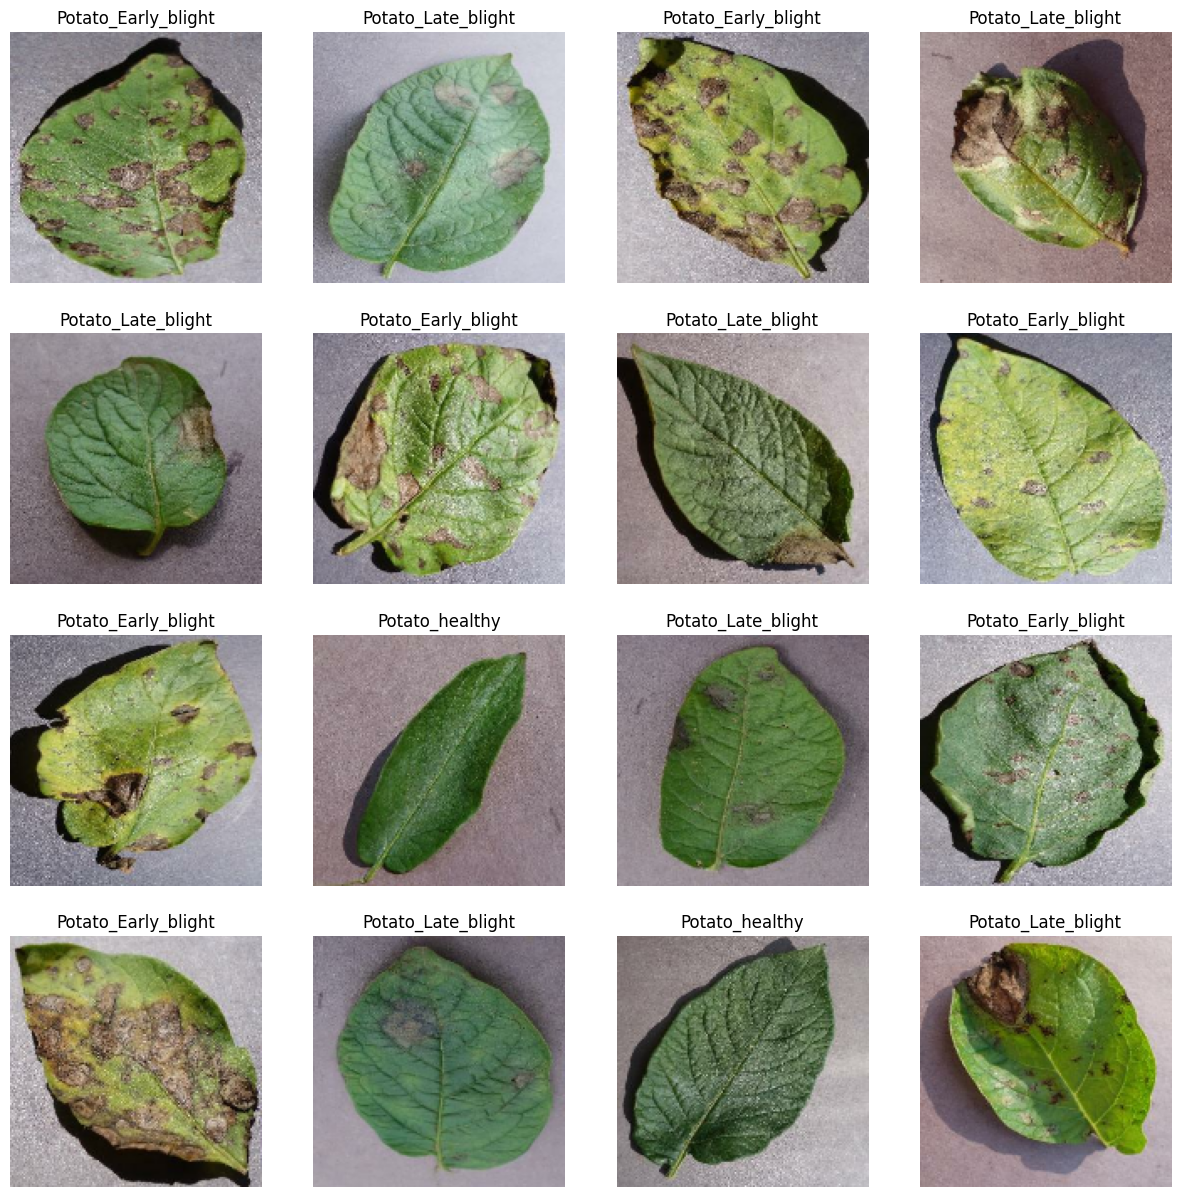

In [28]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.shape)
    print(label_batch.numpy())
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(image_batch[i].numpy().astype(int)) 
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [30]:
from modules import utils

train, val, test = utils.dataset_partition(dataset)
print(len(train), len(val), len(test))

54 6 8


In [31]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [47]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Data preprocessing
data_preprocess = tf.keras.Sequential([
    Resizing(image_size,image_size),
    Rescaling(1.0/255),
])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
])

In [48]:
image, _ = next(iter(train.take(1)))
print(f'Data pixels before: [{np.min(image.numpy())}; {np.max(image.numpy())}]', )
preprocessing_image = data_preprocess(image, training =True)
print(f'Data pixels before: [{np.min(preprocessing_image.numpy())}; {np.max(preprocessing_image.numpy())}]', )

Data pixels before: [0.0; 253.93634033203125]
Data pixels before: [0.0; 0.9958288669586182]


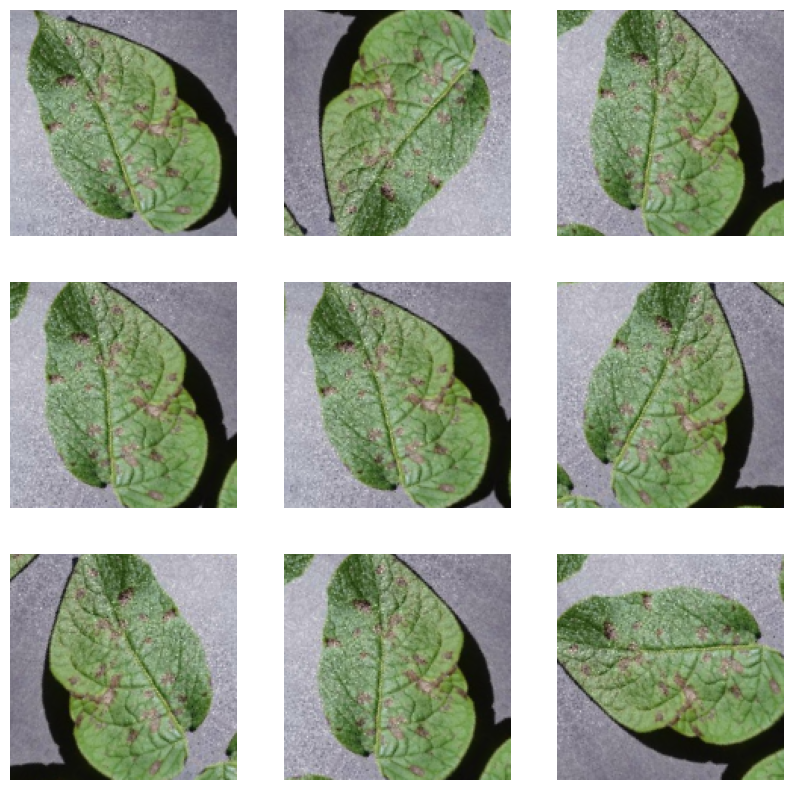

In [49]:
for image, _ in train.take(1):
    first_image = image[0]
    first_image = data_preprocess(first_image,  training =True)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0),  training =True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.axis("off")

In [50]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from modules.History import PlotLossMetric
from modules.CallBacks import CheckPointLoss

In [52]:
# Build CNN model

input_shape = (batch_size, image_size, image_size, 3)

model01 = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2), strides=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax'),
])

model01.build(input_shape=input_shape)
model01.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 150, 150, 3)         0         
                                                                 
 sequential_9 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (32, 148, 148, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (32, 148, 148, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 74, 74, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 72, 72, 64)        

In [53]:
from tensorflow import keras 
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import Precision, Recall

# Set up compile
opt_adam = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
metrics = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
checkpoint_callback = CheckPointLoss('potato')

In [54]:
model01.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metrics],
)

In [55]:
hist01 = model01.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.5791 - accuracy: 0.8628
Epoch 1: val_loss improved from inf to 2.78225, saving model to checkpoints/potato/18\1.ckpt
54/54 [==============================] - 5s 73ms/step - loss: 0.5791 - accuracy: 0.8628 - val_loss: 2.7823 - val_accuracy: 0.5000
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9479
Epoch 2: val_loss did not improve from 2.78225
54/54 [==============================] - 3s 65ms/step - loss: 0.1534 - accuracy: 0.9479 - val_loss: 6.0190 - val_accuracy: 0.5000
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9508
Epoch 3: val_loss did not improve from 2.78225
54/54 [==============================] - 3s 64ms/step - loss: 0.1420 - accuracy: 0.9508 - val_loss: 8.4095 - val_accuracy: 0.5000
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9444
Epoch 4: val_loss did not improve from 2.78225


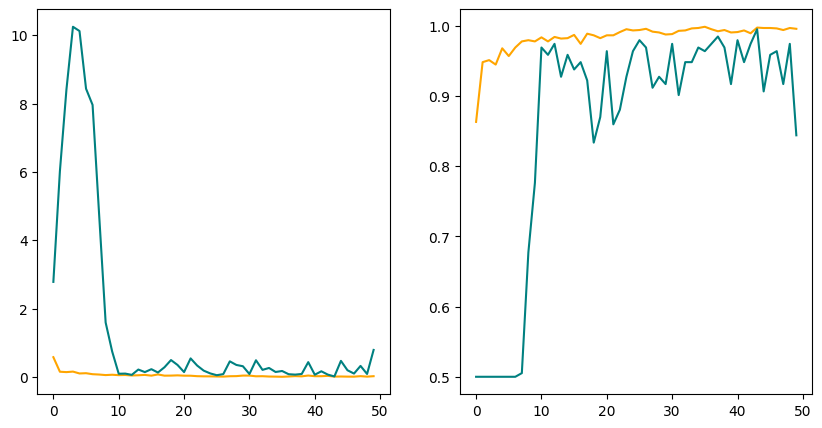

In [56]:
PlotLossMetric(hist01)

In [60]:
model_ver = max([int(i) for i in os.listdir("checkpoints/potato")]+[0])
latest = tf.train.latest_checkpoint(f"checkpoints/potato/{model_ver}")
print(latest)
model01.load_weights(latest)
scores = model01.evaluate(test)
scores

checkpoints/potato/18\44.ckpt
8/8 [==============================] - 0s 19ms/step - loss: 0.1159 - accuracy: 0.9741


[0.11589934676885605, 0.9741379022598267]

In [63]:
hist01_cont = model01.fit(
    train,
    epochs=epochs+50,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    initial_epoch=hist01.epoch[-1],
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 50/100
54/54 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9988
Epoch 50: val_loss did not improve from 0.01574
54/54 [==============================] - 4s 64ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.3577 - val_accuracy: 0.9323
Epoch 51/100
54/54 [==============================] - ETA: 0s - loss: 0.0139 - accuracy: 0.9942
Epoch 51: val_loss did not improve from 0.01574
54/54 [==============================] - 3s 64ms/step - loss: 0.0139 - accuracy: 0.9942 - val_loss: 0.3901 - val_accuracy: 0.9323
Epoch 52/100
54/54 [==============================] - ETA: 0s - loss: 0.0116 - accuracy: 0.9942
Epoch 52: val_loss did not improve from 0.01574
54/54 [==============================] - 3s 64ms/step - loss: 0.0116 - accuracy: 0.9942 - val_loss: 0.1249 - val_accuracy: 0.9740
Epoch 53/100
54/54 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9907
Epoch 53: val_loss did not improve from 0.01574
54/54 [===========================

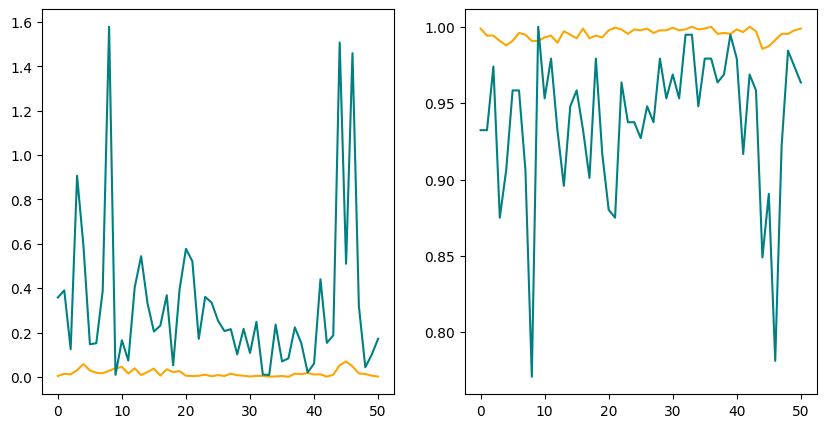

In [64]:
PlotLossMetric(hist01_cont)

In [72]:
model01.load_weights("checkpoints/potato/18/59.ckpt")
scores = model01.evaluate(test)
scores

8/8 [==============================] - 0s 16ms/step - loss: 0.0217 - accuracy: 0.9871


[0.02167520858347416, 0.9870689511299133]

In [74]:
utils.save_model(model01, folder_name='potato')

INFO:tensorflow:Assets written to: models/potato/4\assets



    Actual label: Potato_Early_blight
    Predict label: Potato_Early_blight
    


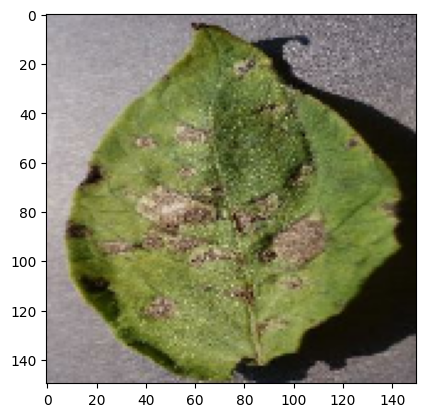

In [75]:
for image_batch, label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype(int)
    first_label = class_names[label_batch[0].numpy()]
    prediction_batch = model01.predict(image_batch)
    predict_label = class_names[np.argmax(prediction_batch[0])]
    print(f'''
    Actual label: {first_label}
    Predict label: {predict_label}
    ''')
    plt.imshow(first_image)

In [76]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predict_label = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predict_label, confidence

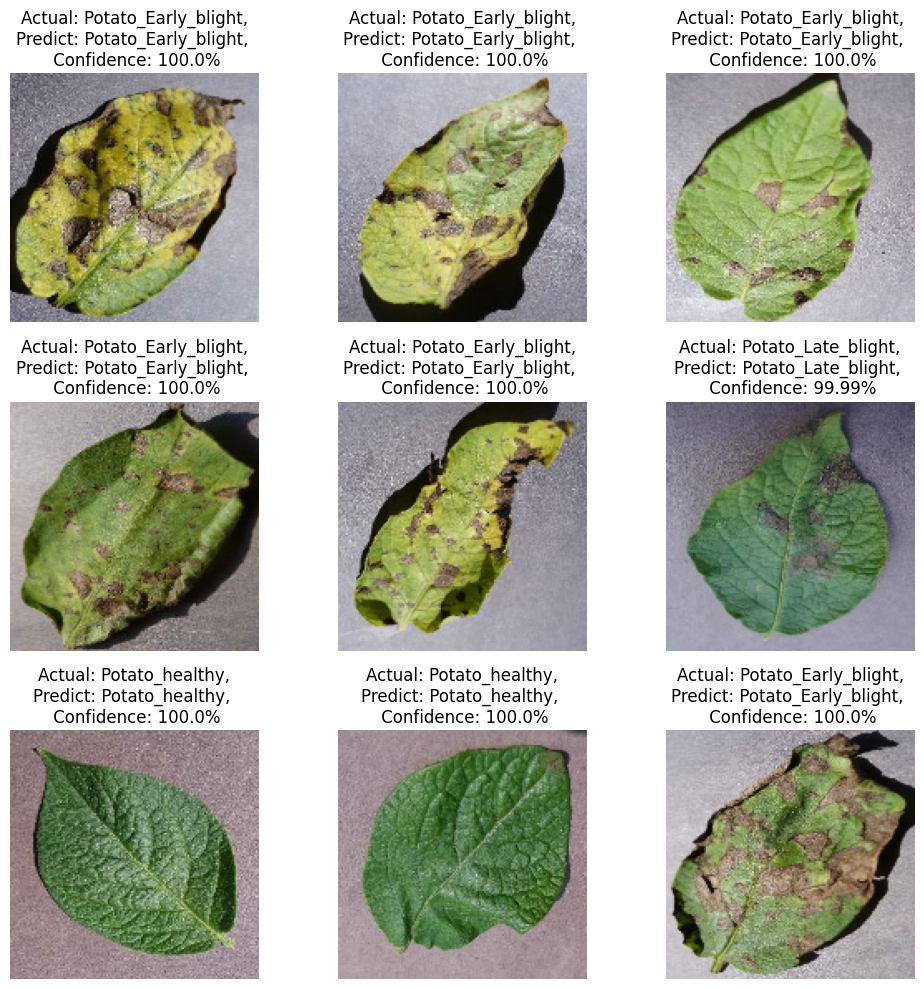

In [77]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(10,10))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = predict(model01, images[i])
                actual_label = class_names[labels[i]]
                    
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=12)
                plt.axis('off')
            fig.tight_layout()

In [187]:
# Save model with updated version
os.makedirs("models", exist_ok=True)

In [189]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
# Build CNN model

input_shape = (batch_size, image_size, image_size, 3)

model02 = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),

])

model02.build(input_shape=input_shape)

model02.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, None)    0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, None)    0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 batch_normalization (BatchN  (32, 254, 254, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)       

In [191]:
model02.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metrics],
)

In [192]:
hist02 = model02.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/50


54/54 [==============================] - 7s 117ms/step - loss: 0.3347 - accuracy: 0.8831 - val_loss: 1.4157 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 5s 101ms/step - loss: 0.1523 - accuracy: 0.9514 - val_loss: 2.4056 - val_accuracy: 0.5052
Epoch 3/50
54/54 [==============================] - 6s 102ms/step - loss: 0.1300 - accuracy: 0.9543 - val_loss: 2.7802 - val_accuracy: 0.5052
Epoch 4/50
54/54 [==============================] - 6s 105ms/step - loss: 0.0847 - accuracy: 0.9716 - val_loss: 3.4497 - val_accuracy: 0.5052
Epoch 5/50
54/54 [==============================] - 5s 102ms/step - loss: 0.0711 - accuracy: 0.9740 - val_loss: 3.6689 - val_accuracy: 0.5052
Epoch 6/50
54/54 [==============================] - 5s 101ms/step - loss: 0.0696 - accuracy: 0.9740 - val_loss: 4.3125 - val_accuracy: 0.5052
Epoch 7/50
54/54 [==============================] - 5s 101ms/step - loss: 0.0496 - accuracy: 0.9850 - val_loss: 3.7873 - val_accuracy: 0.5052
Epoch 8/50
54/54 

8/8 [==============================] - 0s 25ms/step - loss: 0.0917 - accuracy: 0.9741


[0.09166119247674942, 0.9741379022598267]

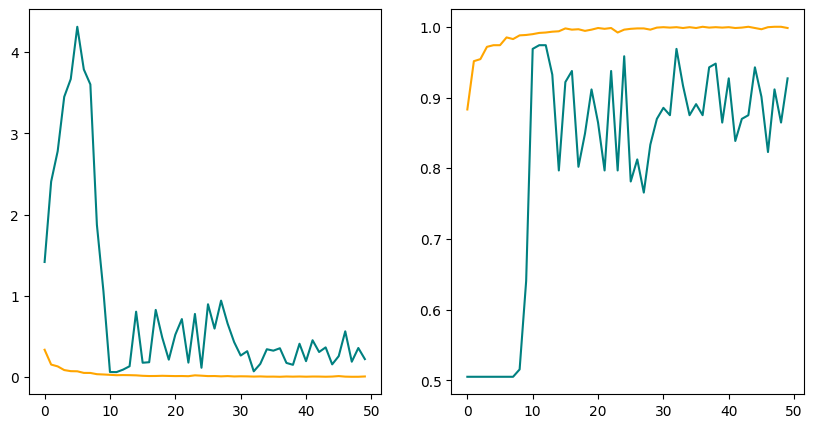

In [193]:
PlotLossMetric(hist02)
scores = model02.evaluate(test)
scores

In [194]:
utils.save_model(model02, 'potato')

INFO:tensorflow:Assets written to: models/model_v02\assets


In [26]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
# Build CNN model

model03 = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),

])

model03.build(input_shape=input_shape)

model03.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 batch_normalization_15 (Bat  (32, 254, 254, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (32, 125, 125, 64)       

In [27]:
model03.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metrics],
)

In [29]:
hist03 = model03.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.4383 - accuracy: 0.8391
Epoch 1: val_loss improved from inf to 1.28034, saving model to checkpoints/potato/9\1.ckpt
54/54 [==============================] - 19s 197ms/step - loss: 0.4383 - accuracy: 0.8391 - val_loss: 1.2803 - val_accuracy: 0.4323
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9317
Epoch 2: val_loss did not improve from 1.28034
54/54 [==============================] - 8s 142ms/step - loss: 0.1935 - accuracy: 0.9317 - val_loss: 2.4597 - val_accuracy: 0.4323
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9427
Epoch 3: val_loss did not improve from 1.28034
54/54 [==============================] - 8s 140ms/step - loss: 0.1560 - accuracy: 0.9427 - val_loss: 3.8020 - val_accuracy: 0.4323
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss: 0.1107 - accuracy: 0.9560
Epoch 4: val_loss did not improve from 1.280

In [ ]:
utils.save_model(model03, 'potato')

In [79]:
model03 = tf.keras.models.load_model("models/potato/3")

In [84]:
dataset_256 = tf.keras.preprocessing.image_dataset_from_directory(
    "data\data1\Potato",
    shuffle=True,
    image_size=(256,256),
    batch_size=batch_size,
)

train_256, val_256, test_256 = utils.dataset_partition(dataset_256)
train_256 = train_256.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_256 = val_256.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_256 = test_256.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

Found 2152 files belonging to 3 classes.


In [85]:
scores_256 = model03.evaluate(test_256)
scores_256

8/8 [==============================] - 4s 108ms/step - loss: 0.0140 - accuracy: 0.9957


[0.01398029550909996, 0.9956896305084229]

In [97]:
import time
import tensorflow as tf


# Define a function to test a model
def test_model(model, dataset, verbose=0):
    start_time = time.time()

    # Assuming your test_dataset is a tf.data.Dataset
    test_results = model.evaluate(dataset)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if verbose:
        print(f"Testing time for model: {elapsed_time:.2f} seconds")
        print(f"Test loss: {test_results[0]:.4f}")
        print(f"Test accuracy: {test_results[1]:.4f}")

    return elapsed_time, test_results[0], test_results[1]

# Number of times to test each model
num_tests = 10

total_time_model1 = 0
total_time_model2 = 0

for _ in range(num_tests):
    time_model1, loss_model1, accuracy_model1 = test_model(model01, test, verbose=1)
    time_model2, loss_model2, accuracy_model2 = test_model(model03, test_256, verbose=1)
    
    total_time_model1 += time_model1
    total_time_model2 += time_model2

average_time_model1 = total_time_model1 / num_tests
average_time_model2 = total_time_model2 / num_tests

print(f"Average test time for model 1: {average_time_model1:.2f} seconds")
print(f"Average test time for model 2: {average_time_model2:.2f} seconds")


8/8 [==============================] - 0s 31ms/step - loss: 0.0217 - accuracy: 0.9871
Testing time for model: 0.39 seconds
Test loss: 0.0217
Test accuracy: 0.9871
8/8 [==============================] - 0s 36ms/step - loss: 0.0140 - accuracy: 0.9957
Testing time for model: 0.32 seconds
Test loss: 0.0140
Test accuracy: 0.9957
8/8 [==============================] - 0s 15ms/step - loss: 0.0217 - accuracy: 0.9871
Testing time for model: 0.14 seconds
Test loss: 0.0217
Test accuracy: 0.9871
8/8 [==============================] - 0s 37ms/step - loss: 0.0140 - accuracy: 0.9957
Testing time for model: 0.32 seconds
Test loss: 0.0140
Test accuracy: 0.9957
8/8 [==============================] - 0s 15ms/step - loss: 0.0217 - accuracy: 0.9871
Testing time for model: 0.14 seconds
Test loss: 0.0217
Test accuracy: 0.9871
8/8 [==============================] - 0s 37ms/step - loss: 0.0140 - accuracy: 0.9957
Testing time for model: 0.33 seconds
Test loss: 0.0140
Test accuracy: 0.9957
8/8 [=================

In [110]:
for img, labels in test:
    print(labels)

tf.Tensor([0 1 1 2 0 0 0 1 0 0 1 1 1 0 2 0 0 2 0 1 0 2 1 1 0 0 0 1 1 2 1 0], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 2 1 0 2 0 1], shape=(32,), dtype=int32)
tf.Tensor([1 1 2 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 2], shape=(32,), dtype=int32)
tf.Tensor([0 0 0 0 0 1 2 2 0 1 1 0 1 1 1 0 2 0 1 2 0 0 1 1 1 0 1 1 1 2 2 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 0 0 1 1 1 1], shape=(8,), dtype=int32)
tf.Tensor([0 1 1 2 0 1 1 0 1 0 1 1 0 2 1 0 1 0 1 0 1 0 1 2 2 0 1 1 0 1 0 1], shape=(32,), dtype=int32)
tf.Tensor([1 0 1 2 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 2 1 0 1 0 1 1 1 1 1], shape=(32,), dtype=int32)
tf.Tensor([0 1 1 1 0 0 0 0 0 1 2 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 2 0 0], shape=(32,), dtype=int32)


In [146]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Initialize lists to store per-class precision and recall
precision_scores = []
recall_scores = []
confusion_matrix_values = np.zeros((num_classes, num_classes), dtype=int)

for images, labels in test:
    predictions = model01.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate precision and recall for each class
    precision = precision_score(labels, predicted_labels, average=None)
    recall = recall_score(labels, predicted_labels, average=None)
    
    # Update confusion matrix
    confusion_matrix_values += confusion_matrix(labels, predicted_labels, labels=range(num_classes))
    
    # Append to the lists
    precision_scores.extend(precision)
    recall_scores.extend(recall)

# Calculate average precision and recall across all classes
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

f1_score = 2 * (average_precision * average_recall) / (average_precision + average_recall)

# Print average precision and recall
print("Average Precision:")
print(average_precision)
print("Average Recall:")
print(average_recall)
print('F1 Score:')
print(f1_score)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix_values)


Average Precision:
0.9866917502787068
Average Recall:
0.989648033126294
F1 Score:
0.9881676806433627
Confusion Matrix:
[[106   0   0]
 [  2 100   1]
 [  0   0  23]]


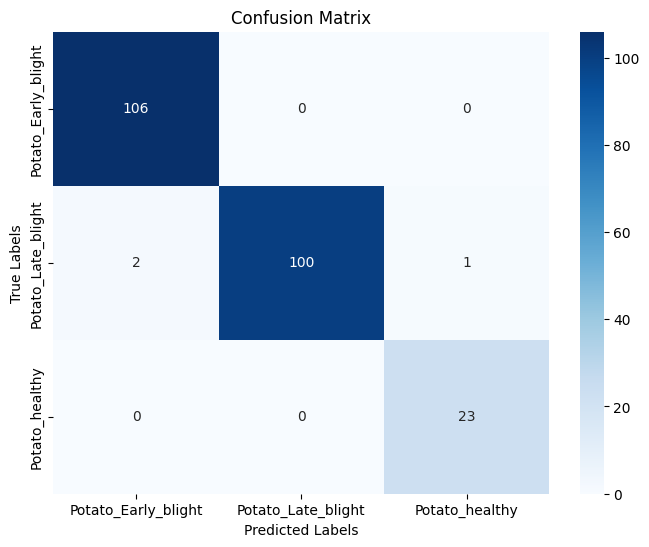

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt


# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
